In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [5]:
## Load dataset
K = 3
N_c, N_s, N_t = 70, 72, 72
N = N_c+N_s+N_t
data_path = data_dir + "ncmm/shapes_c=%d_s=%d_t=%d" % (N_c, N_s, N_t)

OB = torch.from_numpy(np.load(data_path + '/ob.npy')).float()
MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()
ANGLE = torch.from_numpy(np.load(data_path + '/angle.npy')).float()
# STATE = torch.from_numpy(np.load(data_path + '/state.npy')).float()
## Hyper Parameters
NUM_DATASETS = OB.shape[0]

## Train Parameters
NUM_EPOCHS = 500

D = 2
SAMPLE_SIZE = 10
BATCH_SIZE = 20
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))

CUDA = torch.cuda.is_available()
DEVICE = 0
RECON_SIGMA = torch.ones(1) * 0.2
# lg2pi = torch.log(torch.ones(1) * 2 * math.pi)
PATH = 'dec-%dpts-%dsamples' % (N_c+N_s+N_t, SAMPLE_SIZE)
## MOdel Parameters
NUM_HIDDEN_STATE = 64
NUM_HIDDEN_DEC = 32
NUM_HIDDEN_ANGLE = 32
LEARNING_RATE = 1e-3
Train_Params = (NUM_EPOCHS, K, D, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)

In [6]:
from decoder import *
from local_enc_state import *
from local_enc_angle import *
dec_x = Dec_x(K, D, NUM_HIDDEN_DEC, RECON_SIGMA, CUDA, DEVICE)
f_angle = Enc_angle(D, NUM_HIDDEN_ANGLE, CUDA, DEVICE)
f_state = Enc_state(K, D, NUM_HIDDEN_STATE, CUDA, DEVICE)

if CUDA:
    with torch.cuda.device(DEVICE):
        dec_x.cuda()
        f_angle.cuda()
        f_state.cuda()
optimizer =  torch.optim.Adam(list(f_angle.parameters())+list(f_state.parameters())+list(dec_x.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

In [7]:
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    LOSS = 0.0
    indices = torch.randperm(NUM_DATASETS)
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        ob = OB[batch_indices]
        mu = MU[batch_indices]
        ob = shuffler(ob).repeat(SAMPLE_SIZE, 1, 1, 1)
        mu = mu.repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            with torch.cuda.device(DEVICE):
                ob =ob.cuda()
                mu = mu.cuda()
        q_state, p_state = f_state.forward(ob, mu, K)
        log_p_state = p_state['states'].log_prob
        log_q_state = q_state['states'].log_prob
        state = q_state['states'].value ## S * B * N * K
        q_angle, p_angle = f_angle(ob, state, mu)
        log_q_angle = q_angle['angles'].log_prob.sum(-1)
        log_p_angle = p_angle['angles'].log_prob.sum(-1)
        angle = q_angle['angles'].value * 2 * math.pi
        p = dec_x(ob, state, angle, mu)
        ll = p['likelihood'].log_prob.sum(-1) ## S * B * N
        log_w =  ll.detach() + log_p_state + log_p_angle - log_q_state - log_q_angle
        w = F.softmax(log_w, 0).detach()
        loss_phi = (w * log_w).sum(0).sum(-1).mean()
        loss_theta = (- w * ll).sum(0).sum(-1).mean()
        ## gradient step
        loss_phi.backward(retain_graph=True)
        loss_theta.backward()
        optimizer.step()  
        LOSS += loss_theta.detach()
    if epoch % 1 == 0:
        time_end = time.time()
        print('epoch=%d, loss=%.4f (%ds)' % (epoch, LOSS / NUM_BATCHES, time_end - time_start))
        time_start = time.time()

epoch=0, loss=2053.8706 (11s)
epoch=1, loss=261.2861 (11s)
epoch=2, loss=369.5269 (13s)
epoch=3, loss=347.0173 (13s)
epoch=4, loss=299.3704 (13s)
epoch=5, loss=254.1115 (13s)
epoch=6, loss=212.8197 (12s)
epoch=7, loss=148.0399 (13s)
epoch=8, loss=83.4247 (13s)
epoch=9, loss=119.7772 (14s)
epoch=10, loss=79.2094 (12s)
epoch=11, loss=28.5296 (13s)
epoch=12, loss=-23.8233 (13s)
epoch=13, loss=-51.9365 (12s)
epoch=14, loss=-72.5564 (13s)
epoch=15, loss=-78.5834 (13s)
epoch=16, loss=-82.8032 (14s)
epoch=17, loss=-86.3183 (12s)
epoch=18, loss=-89.2769 (13s)
epoch=19, loss=-91.5390 (13s)
epoch=20, loss=-93.8269 (11s)
epoch=21, loss=-95.9719 (12s)
epoch=22, loss=-98.0815 (13s)
epoch=23, loss=-100.1794 (13s)
epoch=24, loss=-101.8226 (13s)
epoch=25, loss=-103.3416 (13s)
epoch=26, loss=-104.6219 (12s)
epoch=27, loss=-106.4202 (13s)
epoch=28, loss=-107.7467 (13s)
epoch=29, loss=-109.0160 (13s)
epoch=30, loss=-110.3175 (13s)
epoch=31, loss=-111.5757 (13s)
epoch=32, loss=-112.6180 (13s)
epoch=33, lo

KeyboardInterrupt: 

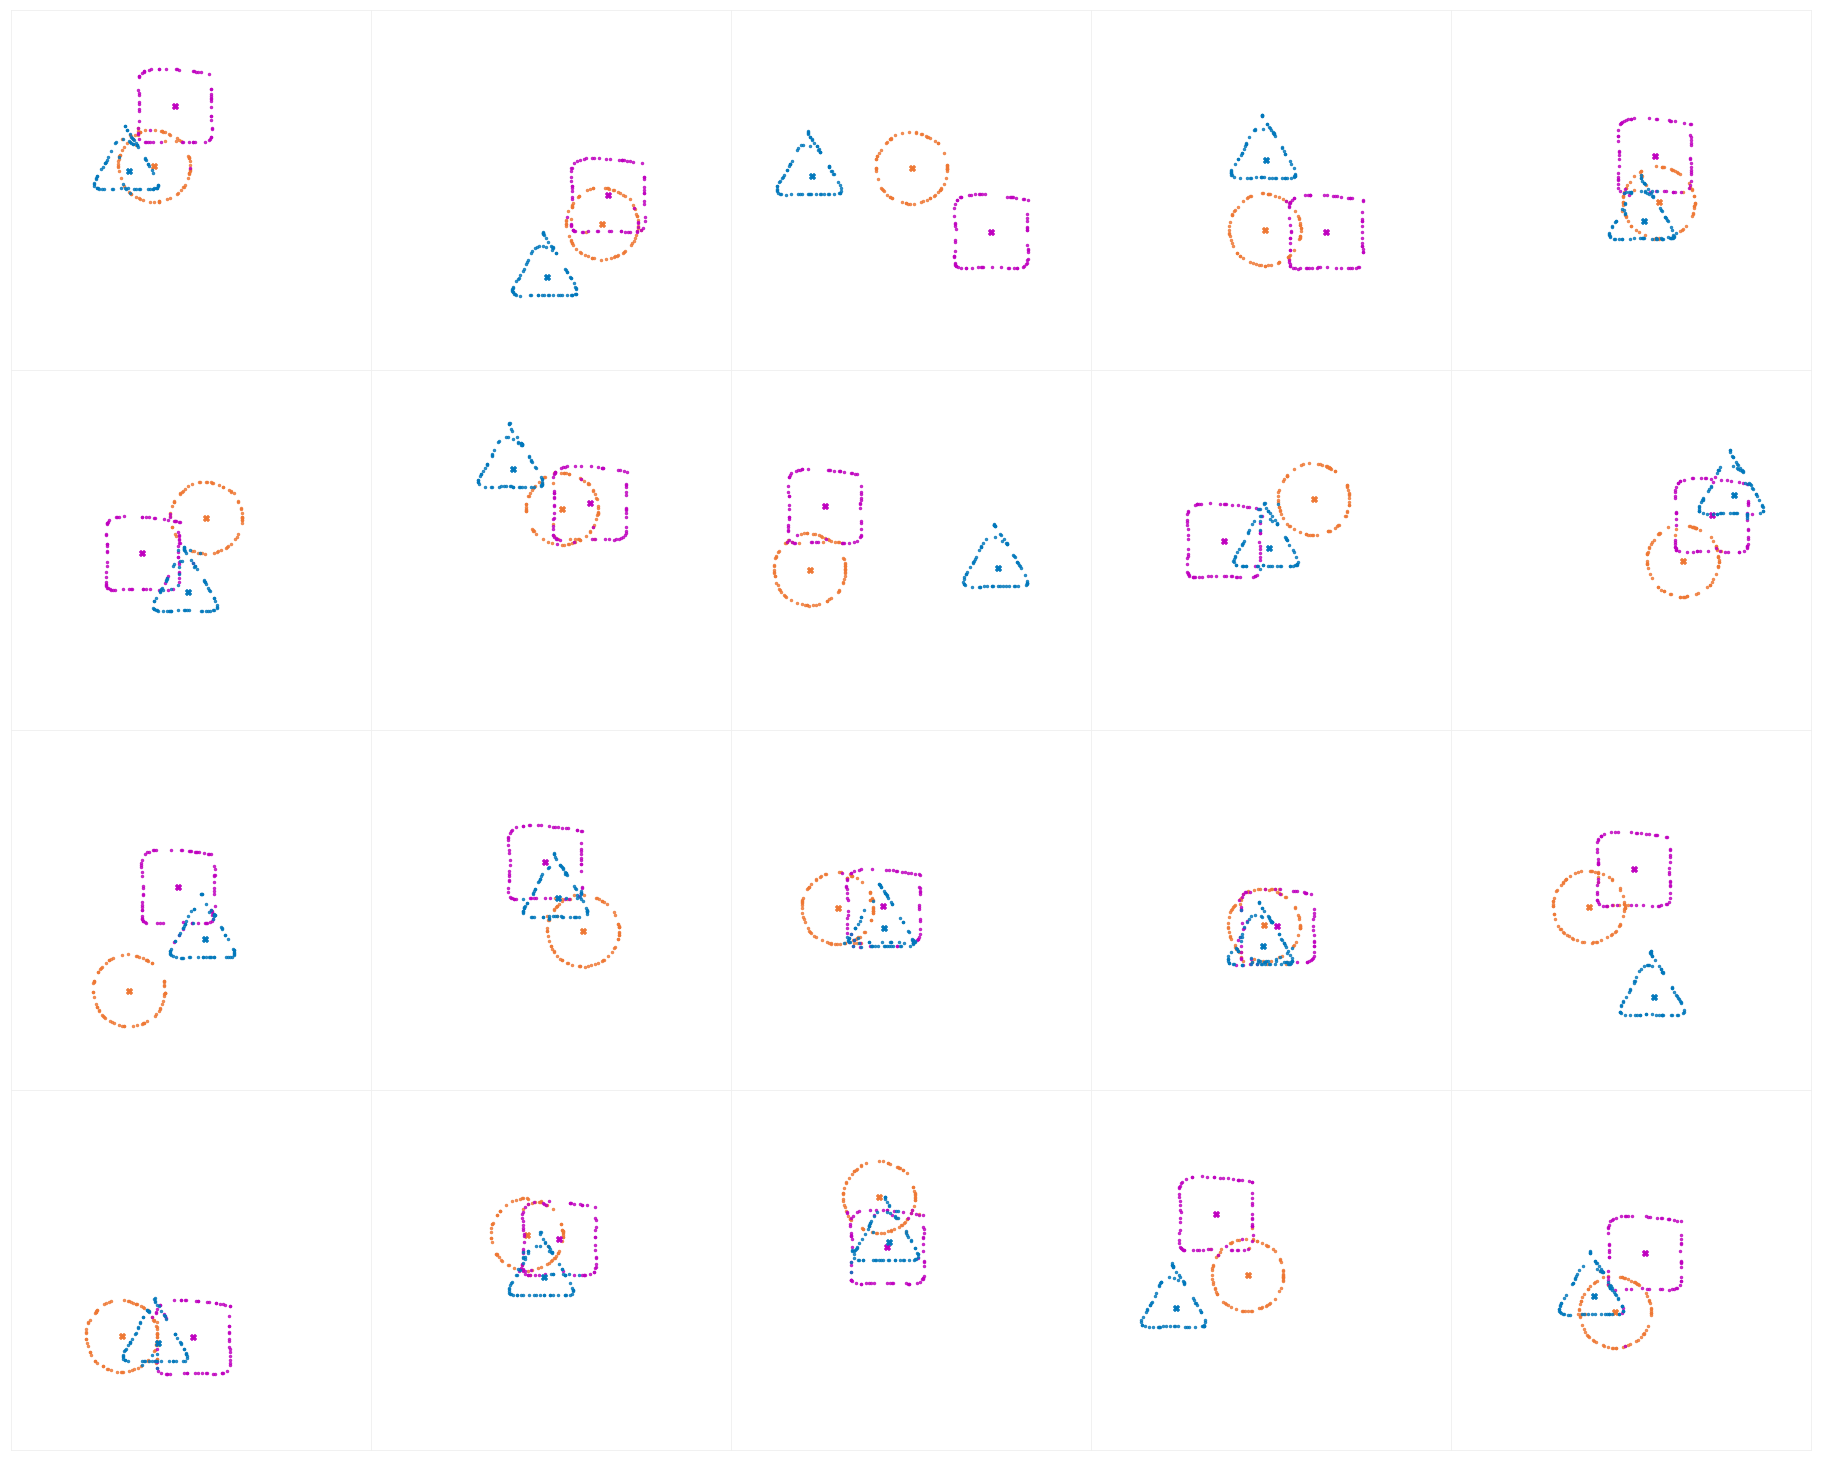

In [8]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from plots import plot_final_samples
    
indices = torch.randperm(NUM_DATASETS)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
ob = OB[batch_indices]
mu = MU[batch_indices]
angle_true = ANGLE[batch_indices]
ob_embedding = torch.cat((ob, angle_true), -1)
ob_embedding = shuffler(ob_embedding).repeat(SAMPLE_SIZE, 1, 1, 1)
mu = mu.repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    with torch.cuda.device(DEVICE):
        ob_embedding =ob_embedding.cuda()
        mu = mu.cuda()
ob = ob_embedding[:,:,:, :2]
angle_true = ob_embedding[:,:,:, -1].unsqueeze(-1)
q_state, p_state = f_state.forward(ob, mu)
log_p_state = p_state['states'].log_prob
log_q_state = q_state['states'].log_prob
state = q_state['states'].value ## S * B * N * K
q_angle, p_angle = f_angle(ob, state, mu)
log_q_angle = q_angle['angles'].log_prob.sum(-1)
log_p_angle = p_angle['angles'].log_prob.sum(-1)
angle = q_angle['angles'].value * 2 * math.pi
p = dec_x(ob, state, angle, mu)

E_state =  q_state['states'].dist.probs[0].cpu().data.numpy()
recon_mu = p['likelihood'].dist.loc[0].cpu().data.numpy()
plot_final_samples(recon_mu, mu[0].cpu().data.numpy(), E_state, K, PATH)

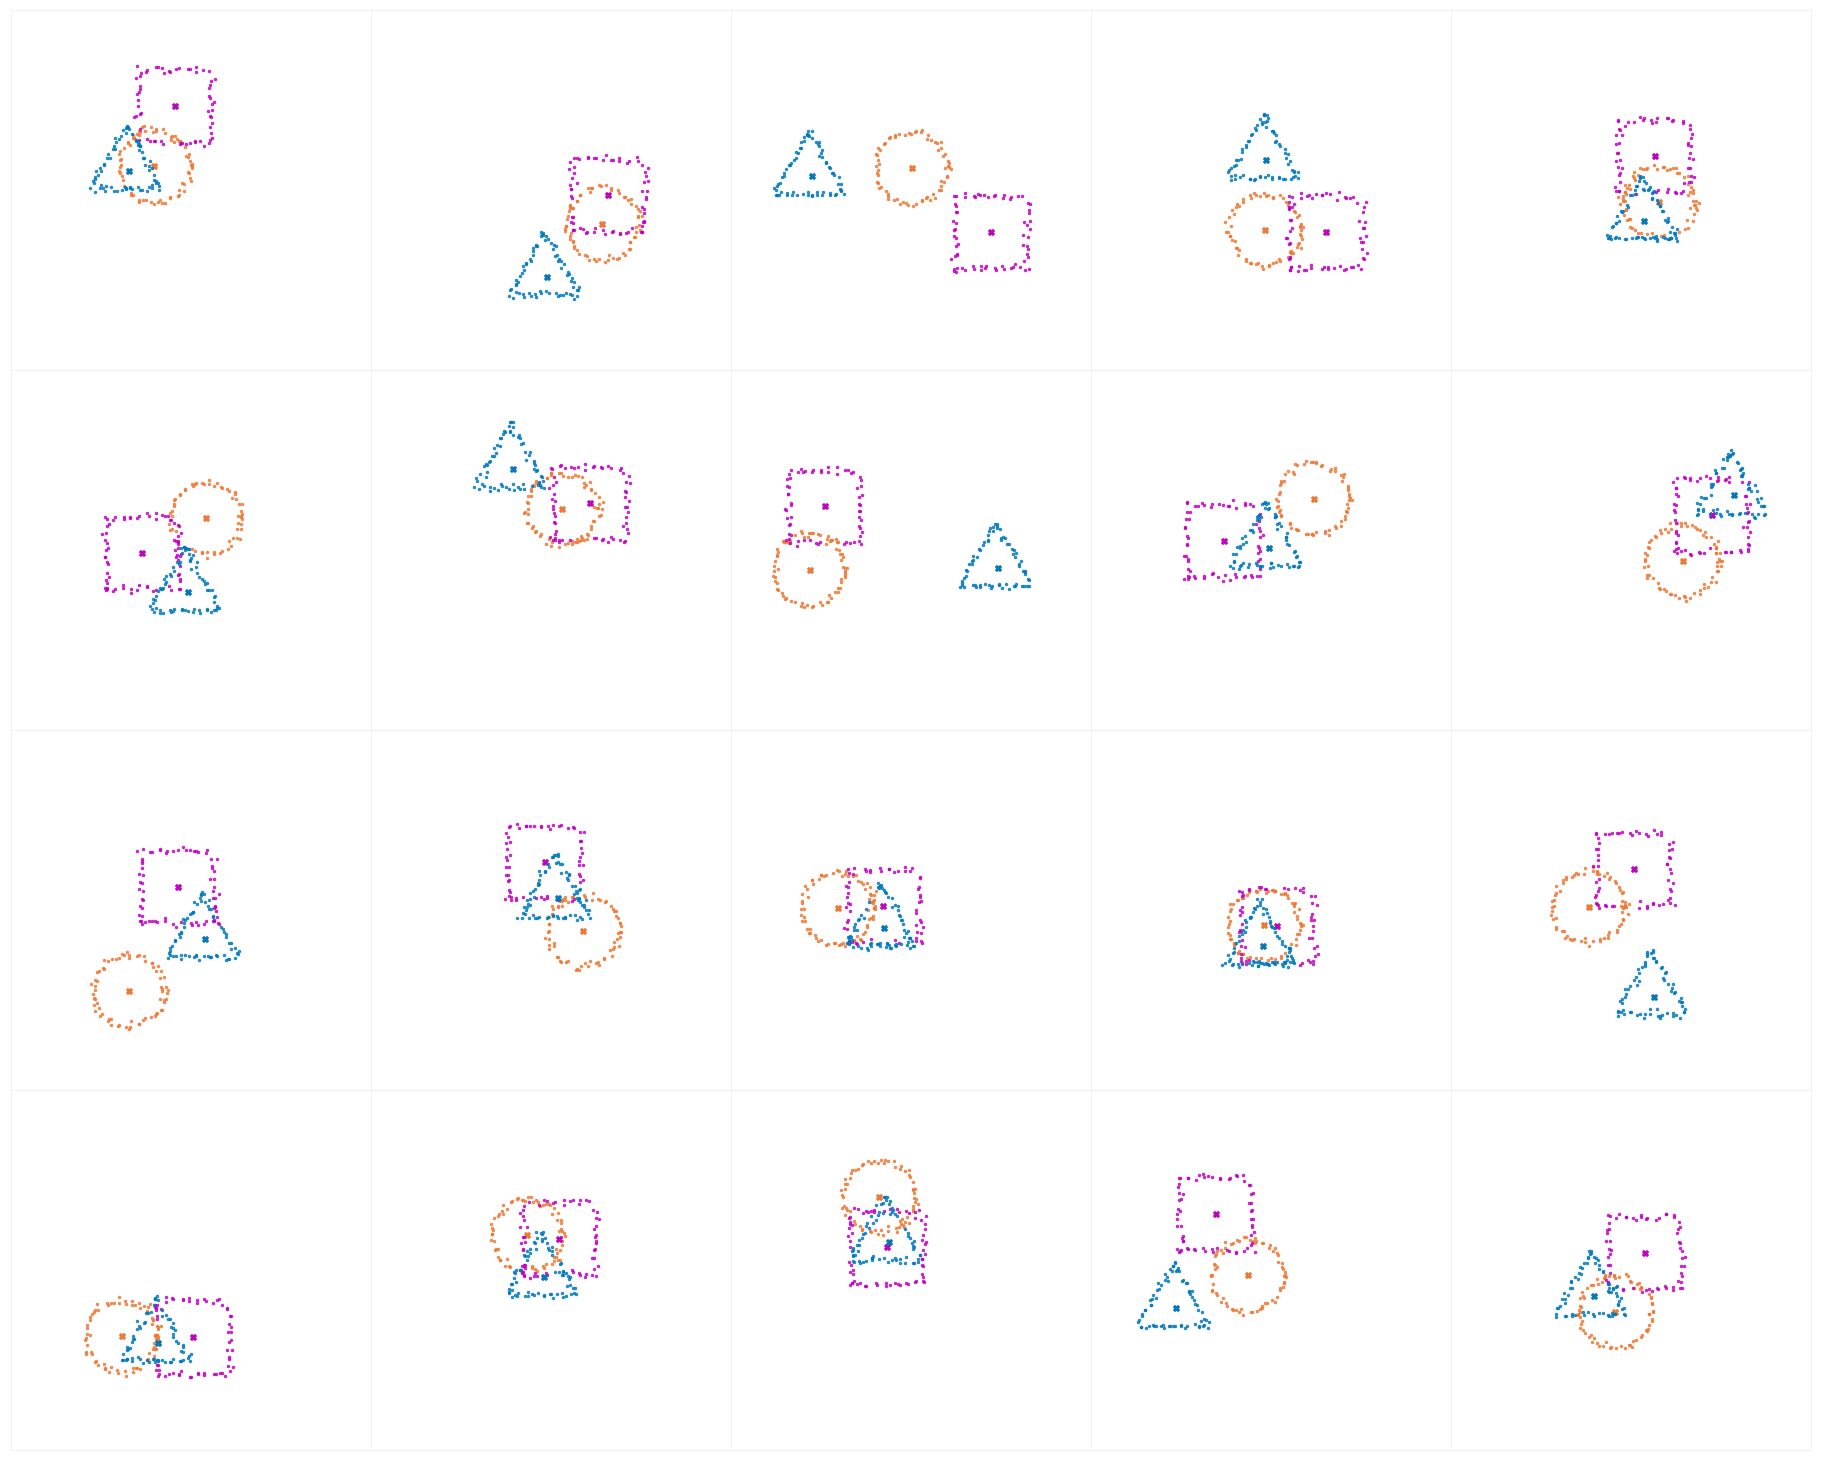

In [9]:
plot_final_samples(ob[0].cpu().data.numpy(), mu[0].cpu().data.numpy(), E_state, K, PATH)